In [76]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [77]:
intervalo = "1d"
df = pd.read_csv(rf'data\binance\2021.5.1_2024.6.23\BTCUSDT_{intervalo}_2021.5.1_2024.6.23.csv')

In [78]:
df['simple_returns'] = df['close'].pct_change(1)
df['log_returns'] = np.log(1+df['simple_returns'])
#long moving average
lma_period = 9
df['LMA'] = df['close'].rolling(lma_period).mean()
#short moving average
sma_period = 4
df['SMA'] = df['close'].rolling(sma_period).mean()
df = df.dropna().reset_index(drop=True)
# df.head(20)

In [79]:
# df.index == (df['SMA'] > df['LMA']).idxmax()
first_buy = pd.Series(df.index == (df['SMA'] > df['LMA']).idxmax(),index=df.index)
trades_df = df[first_buy | (df['SMA'] > df['LMA']).diff()]

In [80]:
def get_strategy_log_returns(df, trades_idx):
    trades = df.loc[trades_idx,'close']
    if len(trades) % 2 != 0:
        mtm = df.close[-1:]
        trades = pd.concat([trades,mtm])
    returns = []
    positions = []
    trades_idx_list = list(trades_idx)
    in_position = False
    for idx,row in df.iterrows():
        positions.append(in_position)
        if in_position:
            r = row['simple_returns']
        else:
            r = 0
        if idx in trades_idx_list:
            trades_list_index = trades_idx_list.index(idx)
            if trades_list_index % 2 == 0: #compra
                in_position = True
            else: #venda
                in_position = False
        returns.append(r)
    df['in_position'] = positions
    df['strategy_log_returns'] = np.where(df['in_position'], df['log_returns'], 0)
    return df

In [81]:
get_strategy_log_returns(df, trades_df.index)

,timestamp_ms,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,timestamp,simple_returns,log_returns,LMA,SMA,in_position,strategy_log_returns
0,1620604800000,58240.83,59500.00,53400.00,55816.14,89586.349250,1620691199999,5.131783e+09,2575419,43057.977029,2.468201e+09,0,2021-05-10,-0.041632,-0.042524,56779.020000,57558.4450,False,0.000000
1,1620691200000,55816.14,56862.43,54370.00,56670.02,64329.540550,1620777599999,3.583031e+09,1911480,30880.828339,1.720076e+09,0,2021-05-11,0.015298,0.015182,56789.221111,57397.2625,True,0.015182
2,1620777600000,56670.02,58000.01,48600.00,49631.32,99842.789836,1620863999999,5.476115e+09,2676826,48299.826001,2.654898e+09,0,2021-05-12,-0.124205,-0.132623,55951.657778,55089.5800,True,-0.132623
3,1620864000000,49537.15,51367.19,46000.00,49670.97,147332.002121,1620950399999,7.303695e+09,3570506,71742.003359,3.558735e+09,0,2021-05-13,0.000799,0.000799,55559.542222,52947.1125,False,0.000000
4,1620950400000,49671.92,51483.00,48799.75,49841.45,80082.204306,1621036799999,4.015905e+09,2095860,37184.128863,1.864163e+09,0,2021-05-14,0.003432,0.003426,54715.691111,51453.4400,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,1718755200000,65175.32,65727.54,64666.00,64974.37,20060.795760,1718841599999,1.307732e+09,1078458,10289.781800,6.708757e+08,0,2024-06-19,-0.003083,-0.003088,66439.374444,65832.7225,False,0.000000
1137,1718841600000,64974.37,66482.94,64559.15,64869.99,24265.290310,1718927999999,1.584896e+09,1282687,11828.879340,7.726461e+08,0,2024-06-20,-0.001606,-0.001608,66167.791111,65381.0025,False,0.000000
1138,1718928000000,64869.99,65066.66,63379.35,64143.56,25993.564420,1719014399999,1.665542e+09,1362617,12543.259600,8.034626e+08,0,2024-06-21,-0.011198,-0.011261,65709.965556,64790.8100,False,0.000000
1139,1719014400000,64143.56,64546.81,63943.82,64262.01,7308.955420,1719100799999,4.700272e+08,562832,3756.290450,2.415839e+08,0,2024-06-22,0.001847,0.001845,65430.965556,64562.4825,False,0.000000


In [82]:
trades = trades_df['close']
trades.index = trades_df['timestamp']
if len(trades) % 2 != 0:
    mtm = df.close[-1:]
    trades = pd.concat([trades,mtm])

In [83]:
buys = trades[::2]
sells = trades[1::2]
profits = (sells.values - buys.values)/buys.values

In [84]:
returns = []
positions = []
trades_idx = list(trades_df.index)
in_position = False
for idx,row in df.iterrows():
    positions.append(in_position)
    if in_position:
        r = row['simple_returns']
    else:
        r = 0
    if idx in trades_idx:
        trades_list_index = trades_idx.index(idx)
        if trades_list_index % 2 == 0: #compra
            in_position = True
        else: #venda
            in_position = False
    returns.append(r)
df['in_position'] = positions

In [85]:
df['strategy_log_returns'] = np.where(df['in_position'], df['log_returns'], 0)

In [86]:
sales_log_returns = [sellprice / buyprice for sellprice,buyprice in zip(sells,buys)]

In [87]:
df['cmm_retorno_acumulado'] = np.exp(df['strategy_log_returns'].dropna()).cumprod()
df['bh_retorno_acumulado'] = np.exp(df['log_returns'].dropna()).cumprod()

In [88]:
df.to_csv(rf'data\resultados\cruz_med_mov_{intervalo}.csv', index=False)

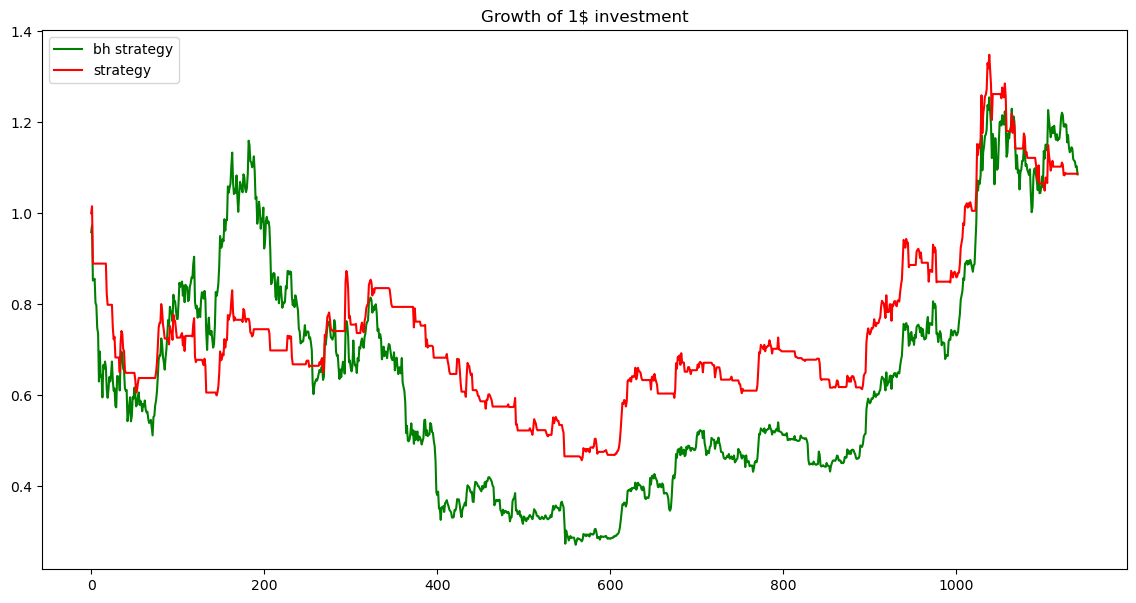

In [89]:
plt.figure(figsize=(14,7))
plt.title('Growth of 1$ investment')
plt.plot(np.exp(df['log_returns'].dropna()).cumprod(), c='green', label='bh strategy')
plt.plot(np.exp(df['strategy_log_returns'].dropna()).cumprod(), c='red', label='strategy')
# plt.plot(pd.Series(profits).dropna().cumprod(), c='blue', label='mr strategy')
plt.legend()

In [90]:
df['simple_returns'] = df['close'].pct_change(1)
df['log_returns'] = np.log(1+df['simple_returns'])

In [91]:
#simula uma venda de bitcoins, retornando o novo saldo de bitcoin e o dinheiro ganho pela venda
def vende(bitcoins, preco):
    if bitcoins > 0:
        return 0,(bitcoins*preco)

#simula uma compra de bitcoins, retornando a quantidade de bitcoins adquirida e a quantidade de dinheiro que sobrou
def compra(dinheiro,preco):
    return (dinheiro/preco),0

In [92]:
qtd_periodos_mm_longa = 9
qtd_periodos_mm_curta = 4
mm_longa_anterior = np.average(df.loc[0:qtd_periodos_mm_longa-1,'close'])
mm_curta_anterior = np.average(df.loc[0:qtd_periodos_mm_curta-1,'close'])
estado_anterior = 'overvalued' if (mm_curta_anterior - mm_longa_anterior > 0) else 'undervalued'
preco_hoje = df.loc[qtd_periodos_mm_longa,'close']
bitcoins,dinheiro = 0,100

if estado_anterior=='overvalued':
    bitcoins,dinheiro = compra(dinheiro, preco_hoje)
else:
    pass
    # bitcoins,dinheiro = vende(bitcoins,preco_hoje)
    
print(bitcoins, dinheiro)
    
for idx in df.index[qtd_periodos_mm_longa+1:]:
    mm_longa_atual = np.average(df.loc[idx-(qtd_periodos_mm_longa-1):idx,'close'])
    mm_curta_atual = np.average(df.loc[idx-(qtd_periodos_mm_curta-1):idx,'close'])
    estado_atual = 'overvalued' if (mm_curta_atual - mm_longa_atual > 0) else 'undervalued'
    preco_hoje = df.loc[idx,'close']
    
    if estado_anterior != estado_atual:
        
        if estado_anterior == 'overvalued' and estado_atual == 'undervalued':
            bitcoins,dinheiro = vende(bitcoins,preco_hoje)
            # print("VENDE!")
        elif estado_anterior == 'undervalued' and estado_atual == 'overvalued':
            bitcoins,dinheiro = compra(dinheiro, preco_hoje)
            # print("COMPRA!")
    
    
            
    else:
        print('Faz nada')
            
    mm_longa_anterior = mm_longa_atual
    mm_curta_atual = mm_curta_atual
    estado_anterior = estado_atual

# print(bitcoins, dinheiro, preco_hoje)

if bitcoins > 0:
    print(preco_hoje*bitcoins)
else:
    print(dinheiro)

0.0027255316081263364 0
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz nada
Faz 